# **Imports**

In [64]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import lime
from lime import lime_image
from captum.attr import IntegratedGradients, DeepLift
import shap
from torch.utils.data import DataLoader, Dataset
from skimage.segmentation import quickshift
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import random

# **Data Prepration**

In [8]:
train_images_dir = "G:/XAI/preprocessed_images/train_images"
train_masks_dir = "G:/XAI/preprocessed_images/train_masks"
val_images_dir = "G:/XAI/preprocessed_images/val_images"
val_masks_dir = "G:/XAI/preprocessed_images/val_masks"

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(112, 112)):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

        # Resize both to match model output
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)

        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)



train_dataset = SegmentationDataset(train_images_dir, train_masks_dir)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



# **Define & Train the Model**

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10


In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.numel()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10]
  Train Loss: 0.3472, Train Accuracy: 97.13%
  Val Loss: 0.2601, Val Accuracy: 98.81%
Epoch [2/10]
  Train Loss: 0.2163, Train Accuracy: 98.84%
  Val Loss: 0.1772, Val Accuracy: 98.99%
Epoch [3/10]
  Train Loss: 0.1520, Train Accuracy: 99.02%
  Val Loss: 0.1282, Val Accuracy: 99.06%
Epoch [4/10]
  Train Loss: 0.1103, Train Accuracy: 99.11%
  Val Loss: 0.0936, Val Accuracy: 99.12%
Epoch [5/10]
  Train Loss: 0.0823, Train Accuracy: 99.16%
  Val Loss: 0.0741, Val Accuracy: 99.07%
Epoch [6/10]
  Train Loss: 0.0630, Train Accuracy: 99.20%
  Val Loss: 0.0571, Val Accuracy: 99.18%
Epoch [7/10]
  Train Loss: 0.0499, Train Accuracy: 99.21%
  Val Loss: 0.0448, Val Accuracy: 99.21%
Epoch [8/10]
  Train Loss: 0.0398, Train Accuracy: 99.25%
  Val Loss: 0.0369, Val Accuracy: 99.23%
Epoch [9/10]
  Train Loss: 0.0329, Train Accuracy: 99.27%
  Val Loss: 0.0362, Val Accuracy: 98.99%
Epoch [10/10]
  Train Loss: 0.0280, Train Accuracy: 99.27%
  Val Loss: 0.0288, Val Accuracy: 99.17%


In [9]:
torch.save(model.state_dict(), "unet_segmentation.pth")


# **XAI Techniques**

In [4]:
torch.cuda.empty_cache()

In [17]:
model = UNet().to(device)
model.load_state_dict(torch.load("unet_segmentation.pth"))
model.eval()
val_iter = iter(val_loader)
inputs, labels = next(val_iter)
test_image = inputs[0:1].to(device)
test_image_np = test_image.cpu().numpy().transpose(0, 2, 3, 1)[0] * 255

## **GradCAM**

In [23]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def hook_fn_forward(module, input, output):
            self.activations = output.detach()
            
        def hook_fn_backward(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.forward_hook = target_layer.register_forward_hook(hook_fn_forward)
        self.backward_hook = target_layer.register_backward_hook(hook_fn_backward)
    
    def __call__(self, x):
        try:
            self.model.eval()
            self.model.zero_grad()
            output = self.model(x)
            score = output.mean()
            score.backward()
            
            if self.gradients is None or self.activations is None:
                raise ValueError("Gradients or activations are None. Check if hooks are properly registered.")
            
            weights = torch.mean(self.gradients, dim=[2, 3])
            batch_size, n_channels, height, width = self.activations.shape
            cam = torch.zeros((batch_size, height, width), device=x.device)
            
            for i in range(batch_size):
                for j in range(n_channels):
                    cam[i] += weights[i, j] * self.activations[i, j]
            
            cam = F.relu(cam)
            cam = F.interpolate(cam.unsqueeze(1), size=(112, 112), mode='bilinear', align_corners=False)
            cam = cam.squeeze(1)
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)
            
            return cam.detach().cpu().numpy()
            
        except Exception as e:
            print(f"Error in GradCAM: {str(e)}")
            return None
        
    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()


c:\Users\yosef\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


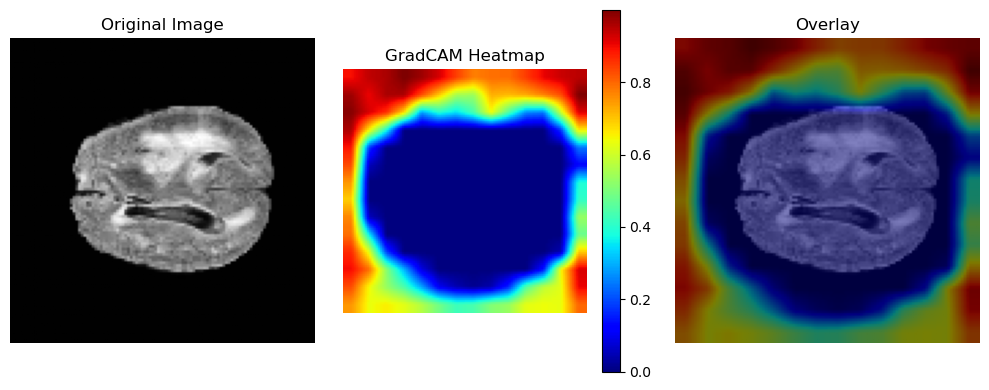

array([[[0.8943841 , 0.8943841 , 0.8943841 , ..., 0.9471923 ,
         0.9471923 , 0.9471923 ],
        [0.8943841 , 0.8943841 , 0.8943841 , ..., 0.9471923 ,
         0.9471923 , 0.9471923 ],
        [0.8943841 , 0.8943841 , 0.8943841 , ..., 0.9471923 ,
         0.9471923 , 0.9471923 ],
        ...,
        [0.74910206, 0.74910206, 0.74910206, ..., 0.79992455,
         0.79992455, 0.79992455],
        [0.74910206, 0.74910206, 0.74910206, ..., 0.79992455,
         0.79992455, 0.79992455],
        [0.74910206, 0.74910206, 0.74910206, ..., 0.79992455,
         0.79992455, 0.79992455]]], dtype=float32)

In [34]:
def visualize_gradcam(model, image, target_layer):
    try:
        grad_cam = GradCAM(model, target_layer)
        
        with torch.set_grad_enabled(True):
            cam_output = grad_cam(image)
        
        grad_cam.remove_hooks()
        
        if cam_output is not None:
            img_display = image.detach().cpu().squeeze().numpy()
            
            plt.figure(figsize=(10, 4))
            
            plt.subplot(131)
            plt.imshow(img_display, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(cam_output[0], cmap='jet')
            plt.title('GradCAM Heatmap')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(cam_output[0], cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        return cam_output
        
    except Exception as e:
        print(f"Error generating GradCAM visualization: {str(e)}")
        return None

target_layer = model.enc4
visualize_gradcam(model, test_image, target_layer)

## **Lime**

In [41]:
class LimeExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.explainer = lime_image.LimeImageExplainer()
        
    def predict_fn(self, images):
        images = images.astype(np.float32) / 255.0
        batch = torch.FloatTensor(images).permute(0, 3, 1, 2)
        if batch.shape[1] == 3:
            batch = batch[:, 0:1, :, :]
        batch = batch.to(self.device)
        with torch.no_grad():
            outputs = torch.sigmoid(self.model(batch))
            return outputs.cpu().numpy().reshape(-1, 112 * 112)
    
    def explain(self, image):
        image_np = image.detach().cpu().squeeze().numpy()
        image_3ch = np.stack([image_np] * 3, axis=-1)
        def segmentation_fn(img):
            return quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)
        explanation = self.explainer.explain_instance(
            image_3ch,
            self.predict_fn,
            top_labels=1,
            hide_color=0,
            num_samples=100,
            num_features=50,
            segmentation_fn=segmentation_fn
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        temp = temp[:, :, 0]
        return temp, mask

  0%|          | 0/100 [00:00<?, ?it/s]

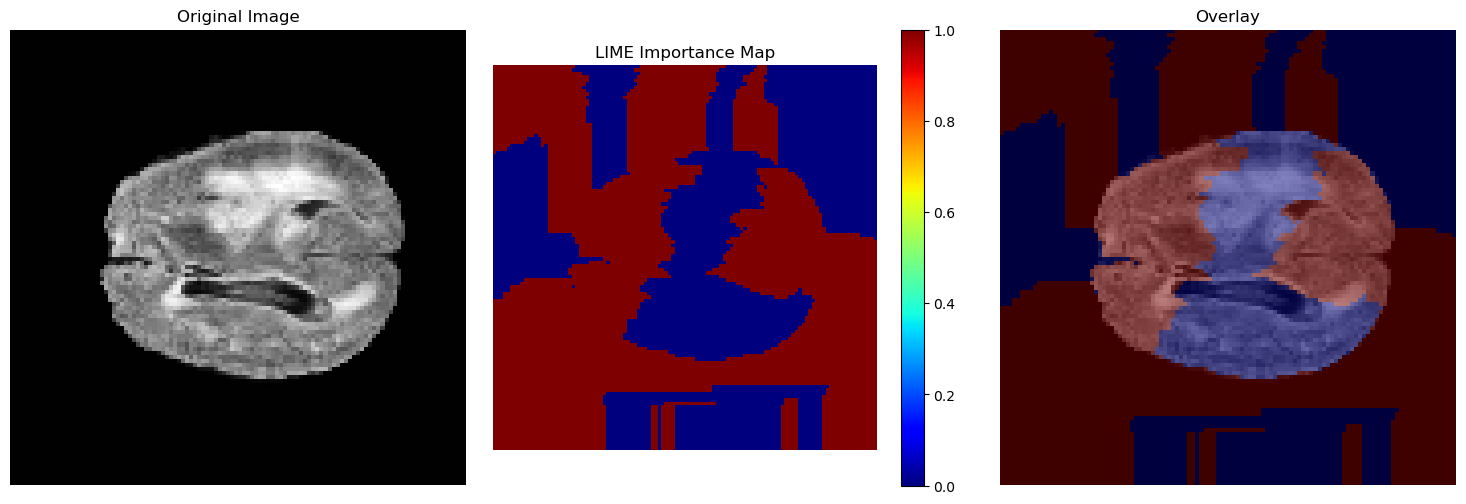

In [43]:
def visualize_lime(model, image, device):
    try:
        lime_explainer = LimeExplainer(model, device)
        temp, mask = lime_explainer.explain(image)
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(image.detach().cpu().squeeze().numpy(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(mask, cmap='jet')
        plt.title('LIME Importance Map')
        plt.colorbar()
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(temp, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in LIME visualization: {str(e)}")
        raise

model.eval()
with torch.no_grad():
    visualize_lime(model, test_image, device)

## **SHAP**

In [62]:
class ShapExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def batch_predict(self, inputs):
        try:
            batch_size = inputs.shape[0]
            images = inputs.reshape(batch_size, 1, 112, 112)
            batch = torch.FloatTensor(images).to(self.device)
            self.model.eval()
            with torch.no_grad():
                outputs = torch.sigmoid(self.model(batch))
                outputs = outputs.mean(dim=[2, 3])
            return outputs.cpu().numpy()
            
        except Exception as e:
            print(f"Error in batch_predict: {str(e)}")
            return None
    
    def explain(self, image, n_samples=10):
        try:
            image_np = image.cpu().squeeze().numpy()
            image_flattened = image_np.reshape(1, -1)
            background = np.zeros((n_samples, 112*112))
            explainer = shap.KernelExplainer(
                model=self.batch_predict,
                data=background,
                link="identity"
            )
            shap_values = explainer.shap_values(
                X=image_flattened,
                nsamples=50,
                l1_reg="num_features(10)"
            )
            return np.array(shap_values).reshape(112, 112)
            
        except Exception as e:
            print(f"Error in SHAP computation: {str(e)}")
            return None

Applying SHAP...
Computing SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]

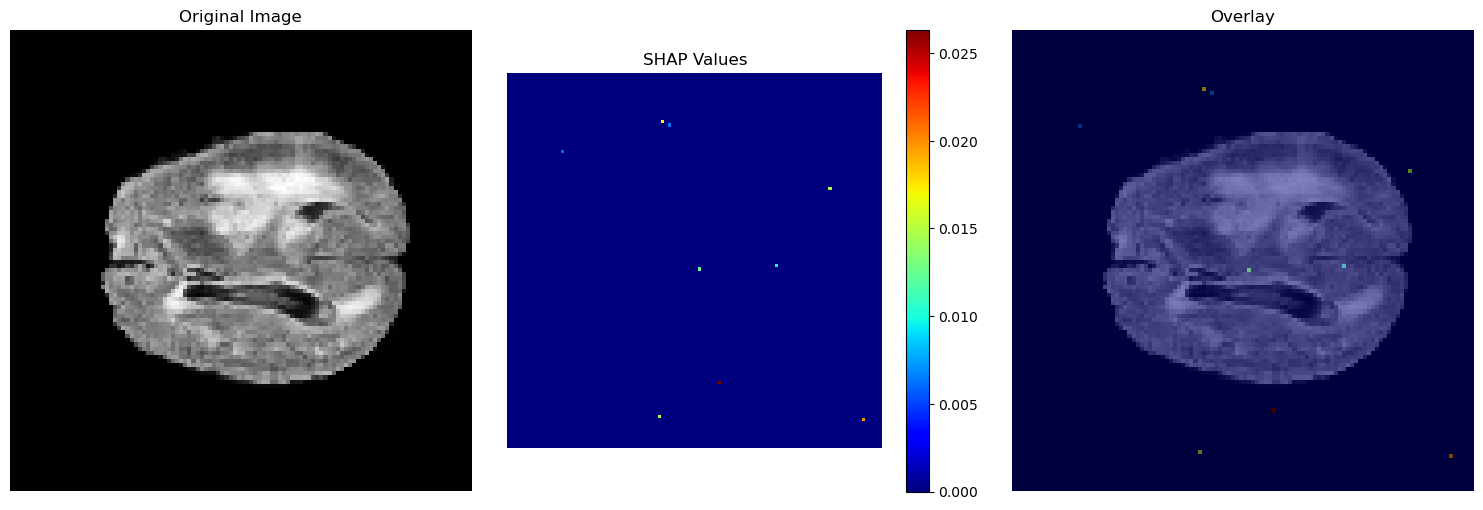

In [63]:
def visualize_shap(model, image, device):
    try:
        print("Computing SHAP values...")
        model = model.cpu()
        image = image.cpu()
        shap_explainer = ShapExplainer(model, "cpu")
        shap_values = shap_explainer.explain(image)
        
        if shap_values is not None:
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(image.squeeze().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            plt.subplot(132)
            plt.imshow(np.abs(shap_values), cmap='jet')
            plt.title('SHAP Values')
            plt.colorbar()
            plt.axis('off')
            plt.subplot(133)
            plt.imshow(image.squeeze().numpy(), cmap='gray')
            plt.imshow(np.abs(shap_values), cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            model = model.to(device)
            
    except Exception as e:
        print(f"Error in SHAP visualization: {str(e)}")
        model = model.to(device)

torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    print("Applying SHAP...")
    visualize_shap(model, test_image, device)

## **Deep Lift**

In [67]:
class DeepLiftExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.wrapped_model = self.create_wrapper()
        self.deep_lift = DeepLift(self.wrapped_model)
    
    def create_wrapper(self):
        class WrapperModel(nn.Module):
            def __init__(self, base_model):
                super().__init__()
                self.base_model = base_model
            
            def forward(self, x):
                output = self.base_model(x)
                return output.mean(dim=[2, 3])
        
        return WrapperModel(self.model)
    
    def explain(self, image):
        try:
            baseline = torch.zeros_like(image).to(self.device)
            
            attributions = self.deep_lift.attribute(
                image,
                baseline,
                return_convergence_delta=False
            )
            
            return attributions.squeeze().cpu().detach().numpy()
            
        except Exception as e:
            print(f"Error in DeepLIFT computation: {str(e)}")
            return None

Applying DeepLIFT...
Computing DeepLIFT values...


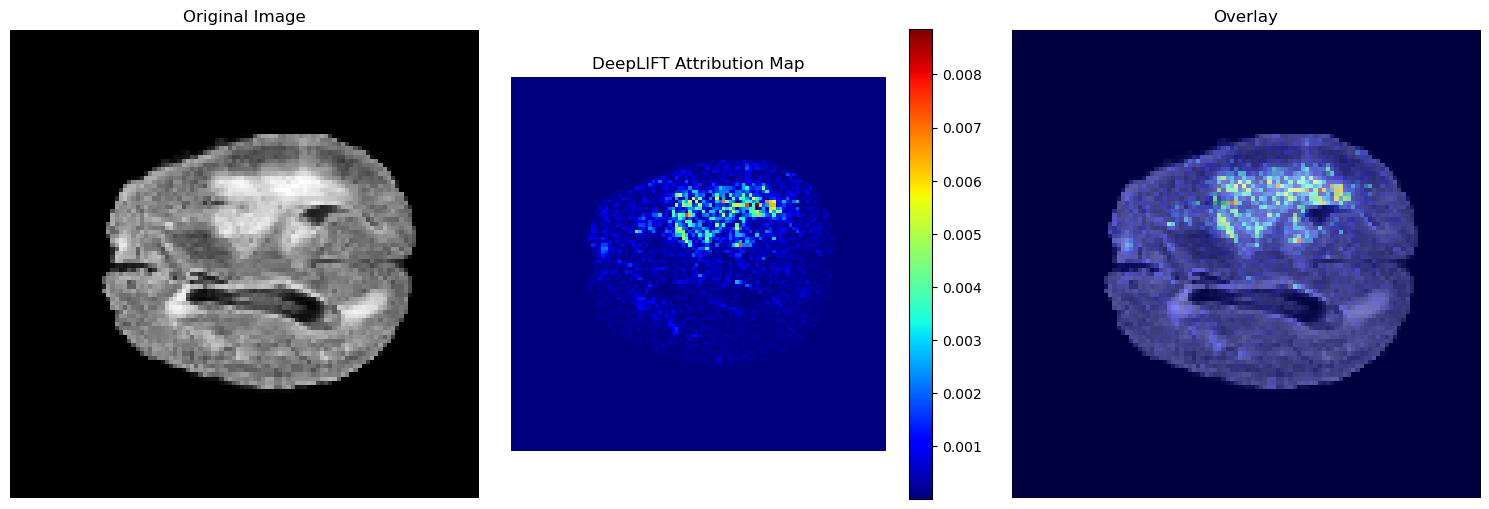

In [68]:
def visualize_deeplift(model, image, device):
    try:
        print("Computing DeepLIFT values...")
        explainer = DeepLiftExplainer(model, device)
        attributions = explainer.explain(image)
        
        if attributions is not None:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(np.abs(attributions), cmap='jet')
            plt.title('DeepLIFT Attribution Map')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
            plt.imshow(np.abs(attributions), cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error in DeepLIFT visualization: {str(e)}")

torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    print("Applying DeepLIFT...")
    visualize_deeplift(model, test_image, device)